In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import ToTensor
from torchvision.models import convnext_tiny, ConvNeXt_Tiny_Weights


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [2]:
X_train = pd.read_csv("data/X_train.csv")
Y_train  = pd.read_csv("data/Y_train.csv")
X_test = pd.read_csv("data/X_test.csv")


# Hyperparameters

In [3]:
# define training hyperparameters
INIT_LR = 5e-5
BATCH_SIZE = 2
EPOCHS = 10
DECAY=0.01

# define the train and val splits
TRAIN_SPLIT = 0.75
VAL_SPLIT = 1 - TRAIN_SPLIT

## Preprocessing 

In [4]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, labels, transform=None):
        self.dataframe = dataframe
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image_path = self.dataframe.iloc[idx]['image_path']
        label = self.labels.iloc[idx].item()
        
        # Open the image 
        image = cv2.imread(image_path)
        # with Image.open(image_path) as image :
        image = self.transform(image)
        return image, label
    
    
# Define transformations

# transform = ConvNeXt_Tiny_Weights.IMAGENET1K_V1.transforms

transform = transforms.Compose([
    ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

# Create datasets and dataloaders
train_dataset = CustomDataset(X_train, Y_train, transform=transform)

# calculate the train/validation split
(train_dataset, validation_dataset) = random_split(train_dataset,
                                                    [TRAIN_SPLIT, VAL_SPLIT],
                                                    generator=torch.Generator().manual_seed(42))


# test_dataset = CustomDataset(X_test, transform=transform)

# train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
# # test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Model definition

In [5]:
# class SmallerBinaryClassificationModel(nn.Module):
#     def __init__(self, input_channels, height, width, output_size):
#         super(SmallerBinaryClassificationModel, self).__init__()
#         self.conv1 = nn.Conv2d(input_channels, 16, kernel_size=3, padding=1)
#         self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
#         self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
#         self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
#         self.flatten = nn.Flatten()
#         self.fc1 = nn.Linear(32 * int(height/4) * int(width/4) , 64)
#         self.fc2 = nn.Linear(64, output_size)
#         self.sigmoid = nn.Sigmoid()

#     def forward(self, x):
#         x = self.conv1(x)
#         x = nn.ReLU()(x)
#         x = self.pool1(x)
#         x = self.conv2(x)
#         x = nn.ReLU()(x)
#         x = self.pool2(x)
#         x = self.flatten(x)
#         x = self.fc1(x)
#         x = nn.ReLU()(x)
#         x = self.fc2(x)
#         x = self.sigmoid(x)
#         return x


In [6]:
# # Create an instance of the model
# model = SmallerBinaryClassificationModel(input_channels =3,
#                                          width = 1024,
#                                          height = 1024,
#                                          output_size = 1  # Binary classification
#                                          ).to(device)

# Transfer learning

Based on convnext tiny, implemented in pytorch from A ConvNet for the 2020s : https://doi.org/10.48550/arXiv.2201.03545
It was pretrained on imagenet. The dataset is really different (it's not satellite imagery) and the images are of size 224*224. According to this article https://www.kaggle.com/code/jhoward/the-best-vision-models-for-fine-tuning/notebook, a comparaison of the transfer learning potential of several models has been made for the the pet dataset and the planet dataset . Because of this dataset similiarity with our current issue we are interested in the models which have work the best for the planet dataset (https://www.kaggle.com/c/planet-understanding-the-amazon-from-space/data). 
The convnext tiny model work with all input sizes and is pretty fast and accurate, so I selected this model as a transfer learning base.

In [7]:
# Initialize model
weights = convnext_tiny
model = convnext_tiny(weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1)

In [8]:
class LayerNorm2d(nn.LayerNorm):
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.permute(0, 2, 3, 1)
        x = nn.functional.layer_norm(x, self.normalized_shape, self.weight, self.bias, self.eps)
        x = x.permute(0, 3, 1, 2)
        return x

model.classifier = nn.Sequential(
                                    LayerNorm2d((768,), eps=1e-06, elementwise_affine=True),
                                    nn.Flatten(start_dim=1, end_dim=-1),
                                    nn.Linear(in_features=768, out_features=1, bias=True),
                                    nn.Sigmoid()
                                )

In [9]:
model = model.to(device)

# Run

In [10]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
valid_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [11]:
# Define loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=INIT_LR)  # Adam optimizer


In [12]:
# initialize a dictionary to store training history
History = {
			"train_loss": [],
			"train_acc": [],
			"val_loss": [],
			"val_acc": []
		  }

In [13]:
def compute_epoch(data_loader,
                  train = True) :
    
    total_loss = 0.0
    accuracy = 0.0
    total_samples = 0
        
    for inputs, labels in data_loader:

        inputs = inputs.to(device)
        labels = labels.to(device).float()  # Ensure labels are float
        batch_size = inputs.size(0)  # Get the actual batch size
        outputs = model(inputs)
        
        # Make sure outputs and labels are of the same shape
        outputs = outputs.view(-1)  # Flatten outputs to shape (batch_size,)
        labels = labels.view(-1)    # Flatten labels to shape (batch_size,)
        
        loss = criterion(outputs, labels)

        if train : 
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        total_loss += loss.item() * batch_size

        accuracy += accuracy_score(labels.cpu().detach().numpy(),
                                  (outputs.cpu().detach().numpy()>= 0.5)) * batch_size
        
        total_samples += batch_size
        
    total_loss /= total_samples
    accuracy /= total_samples
    
    dataset_name = "Train" if train else "Validation" 
    
    print(f"{dataset_name} loss: {loss}, {dataset_name} accuracy: {accuracy}")
        
    return total_loss, accuracy


In [14]:
# Train the model
for epoch in range(EPOCHS):
    
    # print the model training and validation information
    print(f"[INFO] EPOCH: {epoch+1}/{EPOCHS}")
    
    model.train()  # Set model to training mode
    
    train_loss, train_accuracy = compute_epoch(train_loader,
                                                train = True)
    
    model.eval()  # Set model to evaluating mode
    # switch off autograd for evaluation
    with torch.no_grad():    
        valid_loss, valid_accuracy = compute_epoch(valid_loader,
                                                   train = False)

    History["train_loss"].append(train_loss)
    History["val_loss"].append(valid_loss)
    History["train_acc"].append(train_accuracy)
    History["val_acc"].append(valid_accuracy)
    
    #save best model
    best_loss = min(History["val_loss"])
    
    if valid_loss <= best_loss:
      best_model_wts = model.state_dict()

[INFO] EPOCH: 1/10
Train loss: 2.9576950073242188, Train accuracy: 0.7756410256410257
Validation loss: 0.7345632314682007, Validation accuracy: 0.9227799227799228
[INFO] EPOCH: 2/10
Train loss: 1.3269736766815186, Train accuracy: 0.9141025641025641
Validation loss: 0.9401377439498901, Validation accuracy: 0.918918918918919
[INFO] EPOCH: 3/10
Train loss: 0.35142627358436584, Train accuracy: 0.9512820512820512
Validation loss: 0.9394242167472839, Validation accuracy: 0.9073359073359073
[INFO] EPOCH: 4/10
Train loss: 0.08996644616127014, Train accuracy: 0.9666666666666667
Validation loss: 2.4438982009887695, Validation accuracy: 0.918918918918919
[INFO] EPOCH: 5/10
Train loss: 0.10684587061405182, Train accuracy: 0.982051282051282
Validation loss: 0.0409446656703949, Validation accuracy: 0.915057915057915
[INFO] EPOCH: 6/10
Train loss: 0.2766072452068329, Train accuracy: 0.9756410256410256
Validation loss: 2.8050308227539062, Validation accuracy: 0.9305019305019305
[INFO] EPOCH: 7/10
Trai

# Eval

In [15]:
model.load_state_dict(best_model_wts)

torch.save(model,"./models/convnext_tiny_pretrained.pt")

model.eval()

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

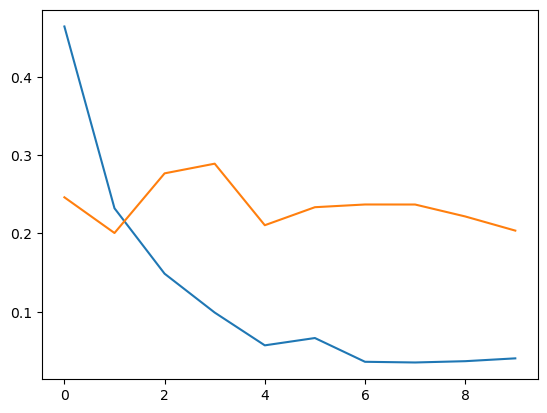

In [16]:
plt.plot(History["train_loss"])
plt.plot(History["val_loss"])

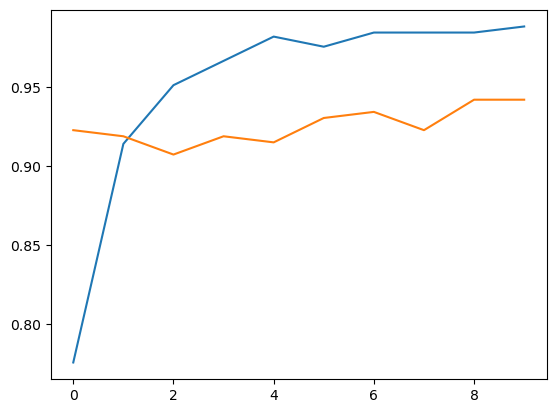

In [17]:
plt.plot(History["train_acc"])
plt.plot(History["val_acc"])

In [18]:
g = ((image, label) for image, label in validation_dataset)


array([0.4475675], dtype=float32)

1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


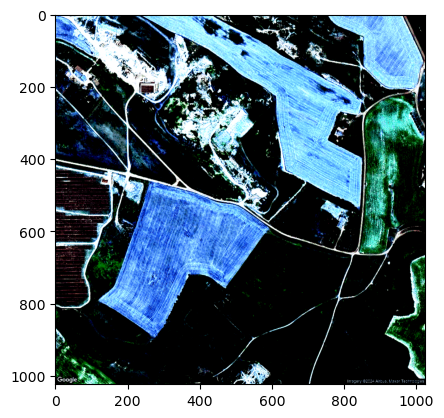

In [32]:
while True :
    image, label = next(g)  
    proba = model(image.unsqueeze(1).permute(1, 0, 2, 3).to(device)).cpu().detach().numpy().flatten()
    
    if (proba>= 0.5)!= label :
        break
    
display(proba)
display(label)
plt.imshow(np.transpose(image.cpu().detach().numpy(), (1, 2, 0)))

# Results 

In [22]:
class Test_dataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image_path = self.dataframe.iloc[idx]['image_path']        
        # Open the image 
        image = cv2.imread(image_path)
        # with Image.open(image_path) as image :
        image = self.transform(image)
        return image
    
# Create datasets and dataloaders
test_dataset = Test_dataset(X_test, transform=transform)

In [23]:
model.load_state_dict(best_model_wts)
model.eval()

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

In [24]:
Y_test = []
for image in test_dataset :
    proba = model(image.unsqueeze(1).permute(1, 0, 2, 3).to(device))
    Y_test.append(int(proba>= 0.5))

In [25]:
Y_test = pd.DataFrame({"output" : Y_test})

Y_test.to_csv('results/Y_test.csv', index=False)

- Accuracy : 94% on validation set 
- Inference time :  1min30 for 525 images 
- Material : GPU RTX 2060 
- Training time : 1h30, can be drastically reduced with similar results

# Other improvements

- AUTO ML : improve hyperparameter optimisation and try other AI methods : it is really time and power consuming 
- SVM : probably worst accuracy but far lighter to train and deploy The problem seemed too complex to use SVM
- data augmentation : increase the train dataset size by inducing roatation or alteration to the original data, it can help increase the dataset size without a new labellisation process. 
- cross validation with k-fold : unbiaised estimation of the validation accuracy but time expensive (5 times mroe for a classic 5-fold)
- try other deeplearning models (vision transformer ?)
- More optimisation for the leraning rate and the gradient decay
- Fix some layers of the pretrained network and update only the head or only some parts of the network
- Build the model from scratch, both accuracy and training time should not be better